<a id = 'title'></a>
# Advanced Modeling

##### Author: Quinci Birker

## Table of Contents

---------------------------------------
1. [Import Dataset and Libraries](#import)
2. [Baseline Modeling - Logistic Regression](#base)
3. [Random Forest Classifier](#RFC)
4. [XGBoost](#XGB)
5. [Summary & Insights](#summary)
---------------------------------------

<a id = 'import'></a>
## Import Dataset and Libraries

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [4]:
# Read in the training dataset
X_train = pd.read_csv('data/X_train_2.csv', index_col=0)
y_train = pd.read_csv('data/y_train_2.csv', index_col=0)

# Read in the testing dataset
X_test = pd.read_csv('data/X_test_2.csv', index_col=0)
y_test = pd.read_csv('data/y_test_2.csv', index_col=0)

##### Sanity check training dataset

In [5]:
X_train.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,publisher_unknown,publisher_Vintage,publisher_HarperCollins,...,desc_would,desc_write,desc_writer,desc_written,desc_wrong,desc_year,desc_yet,desc_york,desc_young,desc_–
0,22.0,666,89,1974,1,0,52,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,176.0,161,83,1983,1,0,95,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,339.0,2535,24,2014,5,1,171,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.105272,0.0,0.0,0.0,0.0
3,201.0,17367,370,2009,7,0,139,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,224.0,94434,389,2016,11,0,125,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.208217,0.0,0.0,0.0,0.0


In [6]:
X_train.shape

(33041, 458)

In [7]:
y_train.head()

,rating
35783,1
39773,0
51074,0
7233,1
6868,0


In [8]:
y_train.shape

(33041, 1)

Scikit-Learn models generally expect the target variable to be a 1D array, so this will need to be reshaped

In [9]:
# Reshape y_train
y_train = y_train.values.ravel()
y_train.shape

(33041,)

##### Sanity check testing dataset

In [10]:
X_test.head()

,pages,numRatings,bbeScore,year,month,series_bool,genre_count,publisher_unknown,publisher_Vintage,publisher_HarperCollins,...,desc_would,desc_write,desc_writer,desc_written,desc_wrong,desc_year,desc_yet,desc_york,desc_young,desc_–
0,346.0,1864,92,2015,9,1,147,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
1,160.0,12646,194,2002,1,1,140,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2,513.0,62049,289,2019,9,1,131,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.112830,0.15885,0.0,0.0,0.0
3,432.0,3347,88,2012,3,0,127,0,0,0,...,0.0,0.106363,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
4,345.0,115,190,2014,6,1,65,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.181669,0.00000,0.0,0.0,0.0


In [11]:
X_test.shape

(8261, 458)

In [12]:
y_test.head()

,rating
33489,1
12086,0
8714,1
36527,1
12745,0


In [13]:
y_test.shape

(8261, 1)

In [14]:
# Reshape the y_test
y_test = y_test.values.ravel()
y_test.shape

(8261,)

<a id = 'base'></a>
## Baseline Modeling

The baseline will be a logistic regression model. This will be used for future testing in how other models perform.

The model will predict whether a book has a good rating (1) or a bad rating (0).<a id = 'base_model'></a>


##### Scale the data

Since the majority of columns are binary, only the non-binary columns will be scaled. 
First, seperate the binary from non-binary columns and then apply the standard scaler to only the non-binary columns. 

In [15]:
# Identify non-binary columns
# non_binary_cols = [col for col in X_train_df_final.columns if len(X_train_df_final[col].unique()) > 2]
non_binary_cols = ['pages', 'numRatings', 'bbeScore', 'year', 'month']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only non-binary columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
X_test_scaled[non_binary_cols] = scaler.transform(X_test[non_binary_cols])

In [16]:
# Instantiate and fit logisitc regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Train and test scores
print(f'Train score: {logreg.score(X_train_scaled, y_train)}')
print(f'Test score: {logreg.score(X_test_scaled, y_test)}')

Train score: 0.6499803274719288
Test score: 0.5202759956421741


/Users/quincibirker/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
# Make predictions on the test data
y_pred_logreg = logreg.predict(X_test_scaled)

The baseline logisitc regression has a train score of 64 percent and a test score of 52 percent. There seems to be overfitting and the overall test accuracy is not strong. This will still be used as a baseline and hopefully testing out different models will improve the prediction accuracy for the test set.

In [18]:
# Extract the coefficients
coefficients = logreg.coef_[0]

# Calculate the odds ratios
odds_ratio = np.exp(coefficients)

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame with feature names and their corresponding coefficients and odds ratios
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds_ratio': odds_ratio
})

# Sort the coefficients from highest to lowest
feature_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

# Display 
feature_coefficients

,Feature,Coefficient,Odds_ratio
5,series_bool,0.801422,2.228709
0,pages,0.495778,1.641775
31,genre_Childrens,0.461944,1.587157
32,genre_Classics,0.387424,1.473181
34,genre_Contemporary Romance,0.283771,1.328129
...,...,...,...
55,genre_Thriller,-0.405328,0.666758
51,genre_Science Fiction,-0.513951,0.598128
47,genre_Novels,-0.544186,0.580314
45,genre_Mystery,-0.623852,0.535876


Highest odds ratio:
- 

Lowest odds ratio:
- 

Notes:
- 

##### Confusion Matrix

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.52      0.02      0.04      3968
           1       0.52      0.98      0.68      4293

    accuracy                           0.52      8261
   macro avg       0.52      0.50      0.36      8261
weighted avg       0.52      0.52      0.37      8261



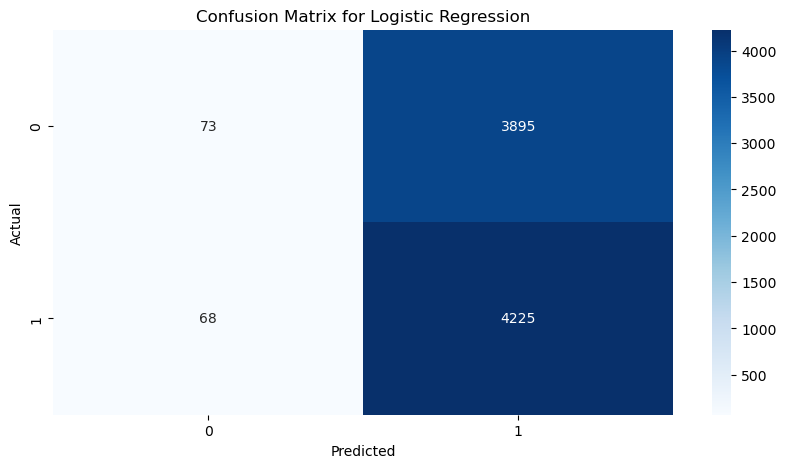

In [19]:
# Classification report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))

# Generate the confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Model Summary

|    | Model Type          | Train Accuracy | Test Accuracy | Precision | Recall | Notes                  |
|----|---------------------|----------------|---------------|-----------|--------|------------------------|
| 1. | Logistic Regression | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters |

<a id = 'RFC'></a>
## Random Forest Classifier

##### Random Search

To efficiently tune hyperparameters, I'll start with a random search to quickly explore a wide range of options. Then, using the insights gained, I'll conduct a more targeted grid search in a narrowed range. This approach combines the speed of random search with the thoroughness of grid search for better results.

In [29]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=55)

# Define the parameter space
param_distributions = {
    'max_depth':list(np.arange(10, 100, step=10)) + [None],
    'n_estimators':np.arange(10, 500, step=50),
    'max_features':randint(1,7),
    'criterion':['gini','entropy'],
    'min_samples_leaf':randint(1,4),
    'min_samples_split':np.arange(2, 10, step=2)
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, 
                                   n_iter=50, cv=5, verbose=2, random_state=55)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Use the best estimator to make predictions
best_rf = random_search.best_estimator_
y_pred_RFC = best_rf.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.6s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.4s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.4s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.5s
[CV] END criterion=entropy, max_depth=80, max_features=1, min_samples_leaf=2, min_samples_split=4, n_estimators=260; total time=   3.5s
[CV] END criterion=entropy, max_depth=60, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=60, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=10; total t

[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.4s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.4s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.3s
[CV] END criterion=gini, max_depth=40, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=60; total time=   1.5s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.4s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2, min_samples_split=2, n_estimators=160; total time=   1.3s
[CV] END criterion=gini, max_depth=30, max_features=1, min_samples_leaf=2

[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=50, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.1s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.2s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.0s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.0s
[CV] END criterion=entropy, max_depth=80, max_featu

[CV] END criterion=gini, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=4, n_estimators=110; total time=   2.6s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.1s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=gini, max_depth=50, max_features=6, min_samples_leaf=3, min_samples_split=4, n_estimators=60; total time=   2.0s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_samples_leaf=1, min_samples_split=6, n_estimators=160; total time=   2.9s
[CV] END criterion=entropy, max_depth=30, max_features=3, min_samples_l

[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.3s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.9s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  14.0s
[CV] END criterion=entropy, max_depth=80, max_features=5, min_samples_leaf=1, min_samples_split=4, n_estimators=310; total time=  13.7s
Best parameters found:  {'criterion': 'entropy', 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 310}


Best parameters found: Best parameters found:  {'criterion': 'entropy', 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 310}

##### Check model accuracy with the best parameters

In [31]:
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5988379130855829


##### Perform a grid search

In [30]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=55)

# Define the parameter grid
param_grid = {
    'criterion': ['entropy'],  # No change needed as it's categorical
    'max_depth': [60, 70, 80],
    'max_features': [4, 5, 6],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [280, 290, 310]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score is: "+str(grid_search.best_score_))

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred_RFC = best_rf.predict(X_test)

Best parameters found:  {'criterion': 'entropy', 'max_depth': 70, 'max_features': 6, 'min_samples_split': 4, 'n_estimators': 310}
Best score is: 0.6878120194891624


Best parameters found:  
- 'criterion': 'entropy'
- 'max_depth': 70
- 'max_features': 6
- 'min_samples_split': 4
- 'n_estimators': 310

##### Random Forest Model with new parameters

In [32]:
params = {
    'criterion': 'entropy',
    'max_depth': 70,  
    'max_features': 6,  
    'min_samples_split': 4,  
    'n_estimators': 310  
}

# Initialize the RandomForestClassifier with these parameters
rf_model = RandomForestClassifier(**params, random_state=55)

# Fit the model to your training data (assuming you have X_train and y_train)
rf_model.fit(X_train, y_train)

# Use rf_model to make predictions 
y_pred_RFC = rf_model.predict(X_test)

print(f'Train score: {rf_model.score(X_train, y_train)}')
print(f'Test score: {rf_model.score(X_test, y_test)}')

Train score: 0.995248327835114
Test score: 0.5988379130855829


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.76      0.24      0.37      3968
           1       0.57      0.93      0.71      4293

    accuracy                           0.60      8261
   macro avg       0.67      0.59      0.54      8261
weighted avg       0.66      0.60      0.54      8261



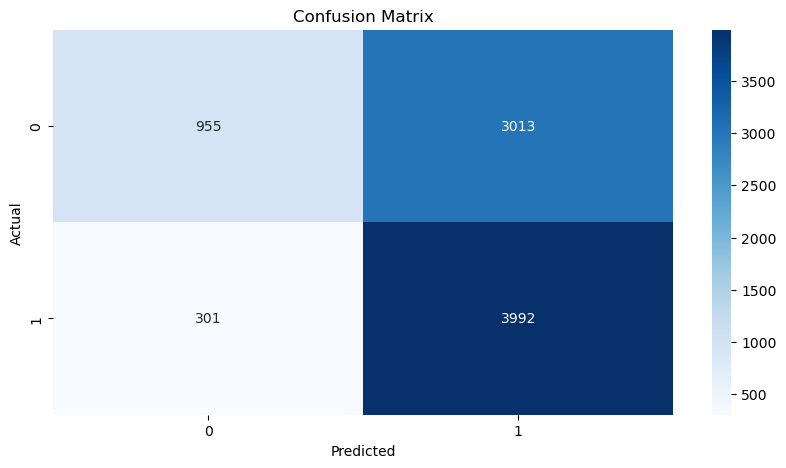

In [33]:
# Classification report
print(classification_report(y_test, y_pred_RFC))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_RFC)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Feature importance

In [34]:
feature_importances = rf_model.feature_importances_

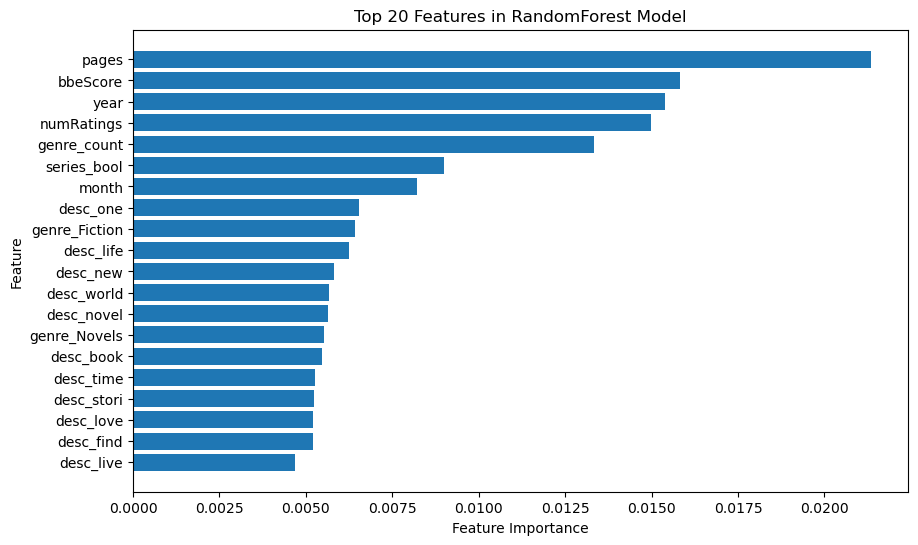

In [35]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Sorting the features with their importance
sorted_idx = np.argsort(feature_importances)[-20:]  # Get indices of top 20 features
sorted_importances = feature_importances[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Features in RandomForest Model")
plt.show()

##### Model Summary

|    | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                  |
|----|--------------------------|----------------|---------------|-----------|--------|------------------------|
| 1. | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters |
| 2. | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | With grid search       |

<a id = 'XGB'></a>
## XGBoost Model

In [36]:
# Fit the model on training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
# Fit the model on training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions for the training data
y_pred_train = xgb_model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

# Make predictions for the test data
y_pred_test = xgb_model.predict(X_test)
predictions_test = [round(value) for value in y_pred_test]

# Evaluate predictions
train_accuracy = accuracy_score(y_train, predictions_train)
test_accuracy = accuracy_score(y_test, predictions_test)

print("Train Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Train Accuracy: 84.80%
Test Accuracy: 58.23%


##### Classification Report & Confusion Matrix

              precision    recall  f1-score   support

           0       0.72      0.22      0.33      3968
           1       0.56      0.92      0.70      4293

    accuracy                           0.58      8261
   macro avg       0.64      0.57      0.51      8261
weighted avg       0.63      0.58      0.52      8261



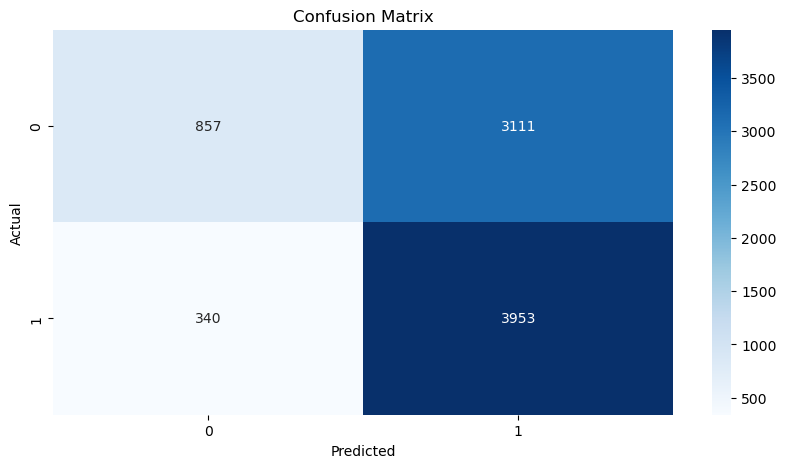

In [38]:
# Classification report
print(classification_report(y_test, predictions_test))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_test)

# Confusion matrix heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues') 
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Model Summary

|     | Model Type               | Train Accuracy | Test Accuracy | Precision | Recall | Notes                    |
|-----|--------------------------|----------------|---------------|-----------|--------|--------------------------|
| 1.  | Logistic Regression      | 62%            | 52%           | 52%       | 97%    | Baseline/No parameters   |
| 2.  | Random Forest Classifier | 100%           | 52%           | 52%       | 100%   | Grid search performed    |
| 3.  | XGBoost                  | 81%            | 53%           | 53%       | 98%    | No grid search performed |

<a id = 'summary'></a>
## Summary & Insights


[Back to the top](#title)